In [1]:
import sys
print('python', sys.version)

import numpy as np
print('numpy', np.__version__)

import pandas as pd
print('pandas', pd.__version__)

import matplotlib as mpl
print('matplotlib', mpl.__version__)

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sci
import glob
import networkx as nx
import Bio.KEGG.KGML.KGML_parser as keg

import pickle
import matplotlib.patches as mpatches

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import cmapPy.pandasGEXpress.parse as cp
import cmapPy.pandasGEXpress.write_gctx as cw

python 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:27:36) [GCC 11.2.0]
numpy 1.26.4
pandas 2.2.3
matplotlib 3.10.0


# entrez to sym gene mapping

In [2]:
# mapping human gene symbol to entrez
dat=pd.read_table('data/Sym2Entrez.txt',sep='\t')
dat.columns=['sym','entrez']
dat=dat.loc[dat['entrez'].notnull()]
dat=dat.loc[dat['sym'].notnull()]
dat['entrez']=dat['entrez'].astype(int).astype(str)
s2e_dic=dat.set_index('sym')['entrez']
e2s_dic=dat.set_index('entrez')['sym']

In [12]:
s2e_dic['PLK1']

'5347'

In [81]:
def get_cell_specific_NCES(cell):
    with open("./results/two_ppi_agg_p_ess_score.pickle", 'rb') as file:
        ess_results_NCES=pickle.load(file)
        
    ess_cell=ess_results_NCES[cell]
    
    regex = rf"^omnipath_all_ppi\|max\|(crispr|chemical)\|(exp_abs\(cor\)|no_cor)\|0\.8$"
    cols_ori = ess_cell.filter(regex=regex).columns
    score_cols=['BES']+[col for col in cols_ori if 'crispr|no_cor' not in col]
    
    selected_df=ess_cell[score_cols]
    
    def get_model_name(score):
        if 'chemical|no_cor' in score:
            return 'NCES (w/o Cor.)'
        if 'crispr|exp_abs(cor)' in score:
            return 'NCES (CRISPR Cor.)'
        if 'chemical|exp_abs(cor)' in score:
            return 'NCES (Comp Cor.)'
        if 'BES' in score:
            return 'BES'
    
    selected_df.columns=[get_model_name(col) for col in selected_df.columns]
    ess_df=selected_df[['BES','NCES (w/o Cor.)','NCES (Comp Cor.)','NCES (CRISPR Cor.)']].copy()


    with open("./data_preproc/omnipath_all_ppi.pickle", 'rb') as file:
        init_net=pickle.load(file)
    
    ess_df['num_of_nei']=0
    for ind in ess_df.index:
        if ind in init_net.nodes():
            neighbors = set(init_net.neighbors(ind))
            ess_df.loc[ind, 'num_of_nei']=len(neighbors)
    
    return ess_df

def explore_candidate_gene(df):
    b1=(df['BES']<df['NCES (w/o Cor.)'])
    b2=(df['NCES (w/o Cor.)']<df['NCES (Comp Cor.)'])
    b3=(df['NCES (Comp Cor.)']<df['NCES (CRISPR Cor.)'])
    sel_df=df.loc[b1&b2&b3].copy()
    sel_df['diff']=sel_df['NCES (CRISPR Cor.)']-sel_df['NCES (w/o Cor.)']
    sel_df=sel_df.sort_values(by='diff', ascending=False)
    return sel_df

def comp_corr_dic(selectd_gene, all_neighbors, score_scheme):
    corr_dic={}
    if score_scheme=='NCES (w/o Cor.)':
        for adj_gene in all_neighbors:
            corr_dic[(selectd_gene, adj_gene)]=1
        return corr_dic
        
    if score_scheme=='NCES (Comp Cor.)':
        with open(f"./data_preproc/{cell}_chemical_expression_data.pickle", 'rb') as file:
            gene_exp_ave=pickle.load(file)
    if score_scheme=='NCES (CRISPR Cor.)':
        with open(f"./data_preproc/{cell}_crispr_expression_data.pickle", 'rb') as file:
            gene_exp_ave=pickle.load(file)
    
    if selectd_gene not in gene_exp_ave.index:
        SELECTED_NODE_LINCS_ERROR

    for adj_gene in all_neighbors:
        if adj_gene in gene_exp_ave.index:
            cor1=gene_exp_ave.loc[selectd_gene].corr(gene_exp_ave.loc[adj_gene])
            corr_dic[(selectd_gene, adj_gene)]=np.exp(abs(cor1))
        else:
            corr_dic[(selectd_gene, adj_gene)]=1
    return corr_dic

def construct_net(corr_dic, ess_df):
    
    vis_net = nx.Graph()
    for edge in corr_dic.keys():
        g1, g2 = edge
        vis_net.add_edge(g1, g2, corr=corr_dic[edge])
    
    for n1 in vis_net.nodes():
        vis_net.nodes[n1]['BES'] = ess_df.loc[n1,'BES']
        
    return vis_net

def draw_net(vis_net, score_scheme, selectd_gene, NCES_val, NCES_rank, ax, NODE_S=400):
    nodes, node_weights = zip(*nx.get_node_attributes(vis_net,'BES').items())
    edges, edge_weights = zip(*nx.get_edge_attributes(vis_net,'corr').items())
    
    base_cmap = plt.cm.Reds
    cmap_for_node = mpl.colors.LinearSegmentedColormap.from_list(
        "Reds_trunc", base_cmap(np.linspace(0.25, 0.6, 256)))

    # Using only 25%~75% of Blues colormap
    base_cmap = plt.cm.Blues
    cmap_for_edge = mpl.colors.LinearSegmentedColormap.from_list(
        "Blues_trunc", base_cmap(np.linspace(0.30, 0.9, 256)))
    
    pos = nx.circular_layout(vis_net)   # layout: circular
    pos[selectd_gene] = [0, 0]
    
    res=nx.draw(vis_net,
                pos,
                node_size=NODE_S,
                node_color=node_weights,
                cmap=cmap_for_node,
                edgecolors="darkgray",
                with_labels=False,
                edge_color=edge_weights,
                edge_cmap=cmap_for_edge,
                ax=ax)
    
    
    node_sym = {node: f"{e2s_dic[node]}\n({vis_net.nodes[node]["BES"]:.2f})" for node in vis_net.nodes()}
    node_sym[selectd_gene]=f"{e2s_dic[selectd_gene]}\n({NCES_val:.2f})"
    
    _=nx.draw_networkx_labels(vis_net, pos, labels=node_sym, font_size=6, font_color="black", ax=ax)
    _=nx.draw_networkx_nodes(vis_net, pos, nodelist=[selectd_gene], node_color="paleturquoise", node_size=NODE_S, ax=ax)
    _=nx.draw_networkx_nodes(vis_net, pos, nodelist=[s2e_dic['PLK1']], node_color="orangered", node_size=NODE_S, edgecolors='k',
                             linewidths=1.5,ax=ax)
   
    edge_labels = { (u, v): f"{d['corr']:.2f}" for u, v, d in vis_net.edges(data=True) }
    _=nx.draw_networkx_edge_labels(vis_net, pos, edge_labels=edge_labels, ax=ax, font_size=6)
    edge_labels = { (u, v): f"{d['corr']:.2f}" for u, v, d in vis_net.edges(data=True) if (u,v)==('4189', '5347')}
    _=nx.draw_networkx_edge_labels(vis_net, pos, edge_labels=edge_labels, ax=ax, font_size=6, font_weight='bold')


In [77]:
ess_df=get_cell_specific_NCES('A375')
sig_df=explore_candidate_gene(ess_df)
sig_avail_df=sig_df.loc[sig_df['num_of_nei']<=15]


# with open("./data_preproc/gs_therTarget_TTD.pickle", 'rb') as file:
#     TTD_gs_dic=pickle.load(file)
#     gs1=TTD_gs_dic['A375']

# with open("./data_preproc/gs_therTarget_drugbank.pickle", 'rb') as file:
#     drugbank_gs_dic=pickle.load(file)
#     gs2=drugbank_gs_dic['A375']
# new_ind=list(set(sig_avail_df.index)&(set(gs1)|set(gs2)))

# sig_avail_df.loc[new_ind]

sig_avail_df
selectd_gene='4189'

,BES,NCES (w/o Cor.),NCES (Comp Cor.),NCES (CRISPR Cor.),num_of_nei,diff
4189,-0.015227,2.062768,3.311559,3.875448,13,1.812679
9587,0.671415,2.200097,3.033663,3.790228,15,1.590131
79682,0.121279,2.090070,3.238904,3.499615,8,1.409545
55781,0.983738,2.262561,2.587179,3.666711,10,1.404150
9047,-0.055783,1.674789,2.427885,2.756933,11,1.082143
...,...,...,...,...,...,...
80036,-0.091918,0.018421,0.022027,0.022654,7,0.004233
55643,-0.024896,0.031826,0.032082,0.035733,3,0.003907
6509,-0.003985,0.036008,0.037147,0.038969,4,0.002961
2747,-0.316416,0.006034,0.008293,0.008565,1,0.002531


'seleted_gene: 4189'

'BES: -0.02'

'BES: 65.87'

Text(0.5, 1.07, 'DNAJB9 gene in A375 cell (BES: -0.02, Rank(%): 65.87)')

Text(0.01, 0.91, '(a)')

Text(0.32, 0.91, '(b)')

Text(0.65, 0.91, '(c)')

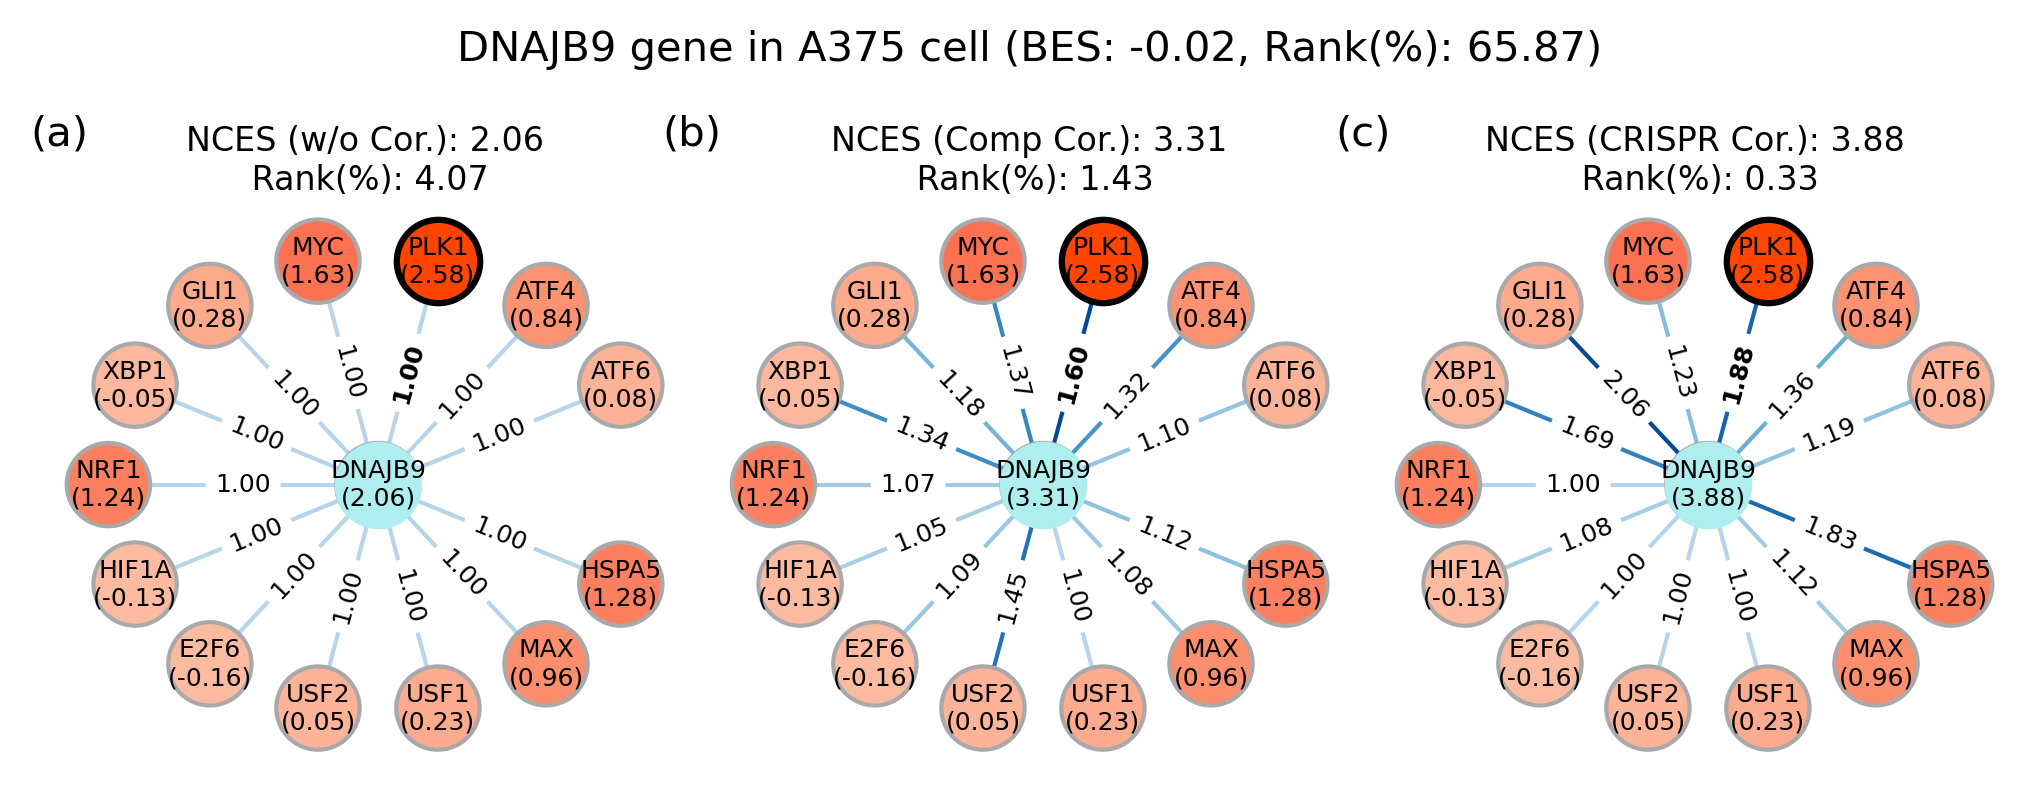

In [82]:
import matplotlib.pyplot as plt
import matplotlib.collections as mc

fig=plt.figure(figsize=(6.8,2.4), dpi=300)
axs=fig.subplots(1,3).flatten()


cell='A375'
selectd_gene='4189'

ess_df=get_cell_specific_NCES(cell)
BES_val = ess_df.loc[selectd_gene, "BES"]
BES_rank = (ess_df["BES"] > BES_val).sum()/len(ess_df)*100
f'seleted_gene: {selectd_gene}'
f'BES: {BES_val:.2f}'
f'BES: {BES_rank:.2f}'
## network load
with open("./data_preproc/omnipath_all_ppi.pickle", 'rb') as file:
    init_net=pickle.load(file)

shared_genes=list(set(ess_df.index)&set(init_net.nodes()))
ess_net=init_net.subgraph(shared_genes).copy()

all_neighbors = set(ess_net.neighbors(selectd_gene))
#print("All neighbors:", len(all_neighbors))

ii=0
for score_scheme in ['NCES (w/o Cor.)', 'NCES (Comp Cor.)', 'NCES (CRISPR Cor.)']:
    NCES_val = ess_df.loc[selectd_gene, score_scheme]
    NCES_rank = (ess_df[score_scheme] > NCES_val).sum()/len(ess_df)*100        

    corr_dic=comp_corr_dic(selectd_gene, all_neighbors, score_scheme)
    vis_net=construct_net(corr_dic, ess_df)

    ax=axs[ii]
    draw_net(vis_net, score_scheme, selectd_gene, NCES_val, NCES_rank, ax)
    _=ax.set_title(f'{score_scheme}: {NCES_val:.2f}\n Rank(%): {NCES_rank:.2f}', fontsize=8)
    ii+=1       
fig.tight_layout()
fig.suptitle(f'{e2s_dic[selectd_gene]} gene in A375 cell (BES: {BES_val:.2f}, Rank(%): {BES_rank:.2f})', fontsize=10, y=1.07)
fig.text(0.01,0.91,'(a)',size=10)
fig.text(0.32,0.91,'(b)',size=10)
fig.text(0.65,0.91,'(c)',size=10)
fig.savefig('figures/DNAJB9_net_vis.png', bbox_inches='tight', dpi=300)